# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "TEST_NULL" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = False # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = None # "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = None # "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "" # <== Pointing a file overrides the value set above.
IB_HYPERPARAMS_FILE = "" # <== Pointing a file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [17]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [5]:
#Setting filenames of files
TB_Train = "../Dataset/TB/TB_CATB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/IB_CATB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [6]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (4574, 101)
IB Train Size: (4574, 101)


### 1.3.3. Previewing datasets

In [7]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrGetDllHandle,GetSystemInfo,NtDelayExecution,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NtClose,NtAllocateVirtualMemory,RegOpenKeyExW,RegCloseKey,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegCloseKey,RegQueryValueExW,RegCloseKey
1,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,GetCursorPos,NtAllocateVirtualMemory,NtFreeVirtualMemory,GetCursorPos,NtAllocateVirtualMemory,NtFreeVirtualMemory,GetCursorPos,NtAllocateVirtualMemory,NtFreeVirtualMemory,GetCursorPos
2,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,NtAllocateVirtualMemory,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrGetProcedureAddress,GetSystemMetrics,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemDirectoryW,LdrLoadDll,CreateThread,FindResourceExW,NtClose,GetSystemMetrics


In [8]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrGetDllHandle,GetSystemInfo,NtDelayExecution,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetProcedureAddress,CreateToolhelp32Snapshot,Thread32First,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,GetSystemDirectoryW,NtDelayExecution,LdrLoadDll,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,SHGetFolderPathW,SetErrorMode,GetFileAttributesW,CreateDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [9]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True)

# 2. Model Training

## 2.1. Setting up the Model

In [24]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS):
    global TUNED_TRAINING
    indexes = get_indexes()
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min') 
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min')

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [25]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS)
tb_catb.fit(X_tb_training, y_tb_training)
end_time("TB_CATB")

#Saving Model as file
tb_catb.save_model("Outputs/"+MODEL_FILENAME+"_TB_CATB.model", format="json")

Learning rate set to 0.016931
0:	learn: 0.6501807	total: 267ms	remaining: 4m 27s
1:	learn: 0.6085008	total: 467ms	remaining: 3m 53s
2:	learn: 0.5748255	total: 572ms	remaining: 3m 10s
3:	learn: 0.5444560	total: 671ms	remaining: 2m 47s
4:	learn: 0.5164860	total: 734ms	remaining: 2m 26s
5:	learn: 0.4859026	total: 857ms	remaining: 2m 22s
6:	learn: 0.4560359	total: 978ms	remaining: 2m 18s
7:	learn: 0.4298819	total: 1.05s	remaining: 2m 10s
8:	learn: 0.4038385	total: 1.18s	remaining: 2m 10s
9:	learn: 0.3791561	total: 1.31s	remaining: 2m 9s
10:	learn: 0.3560526	total: 1.43s	remaining: 2m 8s
11:	learn: 0.3348654	total: 1.56s	remaining: 2m 8s
12:	learn: 0.3174562	total: 1.69s	remaining: 2m 8s
13:	learn: 0.2997229	total: 1.83s	remaining: 2m 8s
14:	learn: 0.2847564	total: 1.95s	remaining: 2m 7s
15:	learn: 0.2705991	total: 2.07s	remaining: 2m 7s
16:	learn: 0.2564029	total: 2.19s	remaining: 2m 6s
17:	learn: 0.2437102	total: 2.32s	remaining: 2m 6s
18:	learn: 0.2340138	total: 2.46s	remaining: 2m 6s
19

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [ ]:
print(classification_report(y_tb_validate, tb_catb.predict(X_tb_validate),digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9781    0.9889       685
           1     0.9787    1.0000    0.9892       688

    accuracy                         0.9891      1373
   macro avg     0.9893    0.9891    0.9891      1373
weighted avg     0.9893    0.9891    0.9891      1373



### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

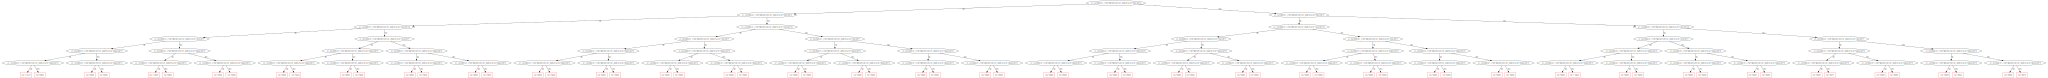

In [ ]:
tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [ ]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS)
ib_catb.fit(X_ib_training, y_ib_training)
end_time("IB_CATB")

#Saving Model as file
ib_catb.save_model("Outputs/"+MODEL_FILENAME+"_IB_CATB.model", format="json")

Learning rate set to 0.016931
0:	learn: 0.6684273	total: 119ms	remaining: 1m 59s
1:	learn: 0.6338212	total: 210ms	remaining: 1m 44s
2:	learn: 0.6069804	total: 270ms	remaining: 1m 29s
3:	learn: 0.5743991	total: 367ms	remaining: 1m 31s
4:	learn: 0.5448633	total: 424ms	remaining: 1m 24s
5:	learn: 0.5165732	total: 532ms	remaining: 1m 28s
6:	learn: 0.4891468	total: 632ms	remaining: 1m 29s
7:	learn: 0.4669423	total: 721ms	remaining: 1m 29s
8:	learn: 0.4412682	total: 868ms	remaining: 1m 35s
9:	learn: 0.4195483	total: 954ms	remaining: 1m 34s
10:	learn: 0.3984963	total: 1.06s	remaining: 1m 35s
11:	learn: 0.3804469	total: 1.14s	remaining: 1m 34s
12:	learn: 0.3633644	total: 1.22s	remaining: 1m 32s
13:	learn: 0.3452960	total: 1.28s	remaining: 1m 29s
14:	learn: 0.3293919	total: 1.34s	remaining: 1m 28s
15:	learn: 0.3113605	total: 1.39s	remaining: 1m 25s
16:	learn: 0.2981125	total: 1.47s	remaining: 1m 24s
17:	learn: 0.2851230	total: 1.52s	remaining: 1m 23s
18:	learn: 0.2735984	total: 1.66s	remaining:

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [ ]:
print(classification_report(y_ib_validate, ib_catb.predict(X_ib_validate),digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9829    0.9914       703
           1     0.9824    1.0000    0.9911       670

    accuracy                         0.9913      1373
   macro avg     0.9912    0.9915    0.9913      1373
weighted avg     0.9914    0.9913    0.9913      1373



### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

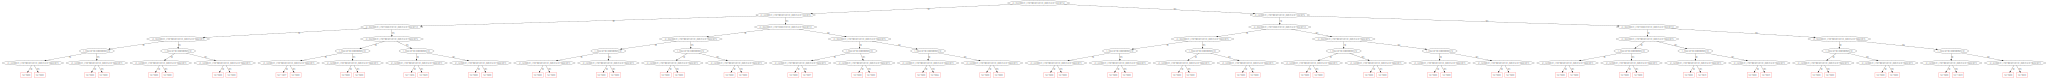

In [ ]:
ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))

In [ ]:
logging("\n")